# Programmatic access to the MICrONS dataset using CAVE

This tutorial walks through the key functions needed to access the MICrONS dataset programmatically and highlights key resources within it. This tutorial is written for the MICrONS dataset specifically, but note that the underlying technology (CAVE) is being used for multiple connectomics dataset.

This tutorial is designed to be run in Google Colab. Some adjustments should be made if run locally, mostly around installation and authentication — see [CAVEclient documentation](https://caveconnectome.github.io/CAVEclient/) for more information.

## CAVEclient and setup

The CAVEclient is a python library that facilitates communication with a CAVE system. It can be installed with `pip`.

In [ ]:
# Run to install caveclient in your colab instance
!pip install -q caveclient

and imported as usual:

In [1]:
import caveclient

## CAVE account setup

Each and every user needs to create a CAVE account and download a user token to access CAVE's services programmatically fully in order to manage server traffic.
The CAVE infrastructure can be read about in more detail on our [preprint](https://www.biorxiv.org/content/10.1101/2023.07.26.550598v1).
The MICrONS data is publicly available which means that no extra permissions need to be given to a new user account to access the data.
Bulk downloads of some static data are also available without an account on [MICrONs Explorer](https://microns-explorer.org/).

A Google account (or Google-enabled account) is required to create a CAVE account.

### Start here if you do not have a CAVE account or are not sure

Login to CAVE to setup a new account. To do this go to this [website](https://minnie.microns-daf.com/materialize/views/datastack/minnie65_public).

### Once you have an account: Setup your token

Create a new token by running the next cell. Then, copy the token and insert it into the argument of the following cell. These two cells should be redone together to make sure that the correct token is stored on your machine. You can copy your token and store on as many machines as you like. If you think your token has been compromised just reset it but rerunning the following cell.

In [ ]:
client = caveclient.CAVEclient()
client.auth.setup_token(make_new=True)

### Set or save your token

From the website that just opened up, paste your token here:

In [ ]:
my_token = "PASTE_TOKEN_HERE"

Were you to run this on your local machine, you should save the token so it will be loaded automatically in the future.

```python
client.auth.save_token(token=my_token, overwrite=True)
```

## Libraries for this notebook

This notebook makes use of a few python libraries for analysis and visualization. These are installed by default in Colab, but if you are running this notebook locally, you may need to install them via pip.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

## Initialize CAVEclient with a datastack

Datasets in CAVE are organized as datastacks. These are a combination of an EM dataset, a segmentation and a set of annotations. The datastack for MICrONS public release is `minnie65_public`. When you instantiate your client with this datastack, it loads all relevant information to access it.

In [3]:
datastack_name = "minnie65_public"
client = caveclient.CAVEclient(datastack_name, auth_token=my_token)

## Materialization versions


Queries to the database for properties like synapses, cell types, and proofreading status are stored in a CAVE database.
All data in CAVE is timestamped for complete reproducibility. For convenience, data is periodically "materialized", where a copy of the database is stored at a specific timestamp and assigned a "version" number. Roughly quarterly, a permanent materialization version is released as the latest public version.

The various CAVEclient functions related to querying these materialized databases are available under `client.materialize`. 

For example, to see which versions are available:

In [4]:
client.materialize.get_versions()

[1078, 117, 661, 343, 1181, 795, 943]

And these are their associated timestamps (all timestamps are in UTC time zone):

In [5]:
for version in client.materialize.get_versions():
    print(f"Version {version}: {client.materialize.get_timestamp(version)}")

Version 1078: 2024-06-05 10:10:01.203215+00:00
Version 117: 2021-06-11 08:10:00.215114+00:00
Version 661: 2023-04-06 20:17:09.199182+00:00
Version 343: 2022-02-24 08:10:00.184668+00:00
Version 1181: 2024-09-16 10:10:01.121167+00:00
Version 795: 2023-08-23 08:10:01.404268+00:00
Version 943: 2024-01-22 08:10:01.497934+00:00


The client will automatically query the latest materialization version, but note that you can specify a `materialization_version` for every query if you want to access a specific version.

## Tables and generally useful information

A datastack has a large number of tables that can be intimidating to traverse at first. CAVE provides several ways to find the tables you may want use. To print all tables that are available run:

In [6]:
client.materialize.get_tables()

['nucleus_alternative_points',
 'allen_column_mtypes_v2',
 'bodor_pt_cells',
 'aibs_metamodel_mtypes_v661_v2',
 'allen_v1_column_types_slanted_ref',
 'aibs_column_nonneuronal_ref',
 'nucleus_ref_neuron_svm',
 'apl_functional_coreg_vess_fwd',
 'vortex_compartment_targets',
 'baylor_log_reg_cell_type_coarse_v1',
 'functional_properties_v3_bcm',
 'l5et_column',
 'pt_synapse_targets',
 'coregistration_auto_phase3_fwd_apl_vess_combined',
 'coregistration_manual_v4',
 'vortex_manual_myelination_v0',
 'synapses_pni_2',
 'nucleus_detection_v0',
 'vortex_manual_nodes_of_ranvier',
 'vortex_astrocyte_proofreading_status',
 'bodor_pt_target_proofread',
 'nucleus_functional_area_assignment',
 'coregistration_auto_phase3_fwd',
 'synapse_target_structure',
 'proofreading_status_and_strategy',
 'aibs_metamodel_celltypes_v661']

For each datastack, CAVE stores information about key data sources and parameters. These can be accessed through:

In [7]:
client.info.get_datastack_info()

{'aligned_volume': {'id': 1,
  'name': 'minnie65_phase3',
  'display_name': 'Minnie65',
  'description': "This is the second alignment of the IARPA 'minnie65' dataset, completed in the spring of 2020 that used the seamless approach.",
  'image_source': 'precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie65/em'},
 'segmentation_source': 'graphene://https://minnie.microns-daf.com/segmentation/table/minnie65_public',
 'skeleton_source': 'precomputed://https://minnie.microns-daf.com/skeletoncache/api/v1/minnie65_public/precomputed/skeleton/',
 'analysis_database': None,
 'viewer_site': 'https://spelunker.cave-explorer.org/',
 'synapse_table': 'synapses_pni_2',
 'soma_table': 'nucleus_detection_v0',
 'local_server': 'https://minnie.microns-daf.com',
 'description': 'This is the publicly released version of the minnie65 volume and segmentation. ',
 'viewer_resolution_x': 4.0,
 'viewer_resolution_y': 4.0,
 'viewer_resolution_z': 40.0,
 'proofreading_status_tabl

For instance, the table with synapses is named `synapses_pni_2` and table with one entry per cell body (i.e. soma) is named `nucleus_detection_v0`. 

## Query 1: Querying cells and their types

### Querying cell bodies

The basic querying function for CAVE is `client.materialize.query_table`. This accepts a table name as the only required parameter and optionally some filters. Let's query the table of all automatically segmented nuclei:

In [8]:
nucleus_table_name = client.info.get_datastack_info()["soma_table"] # We just saw that this should be `nucleus_detection_v0`
nucleus_df = client.materialize.query_table(nucleus_table_name)
nucleus_df.head(5)

,id,created,superceded_id,valid,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,730537,2020-09-28 22:40:41.780734+00:00,NaN,t,32.307937,0,0,"[381312, 273984, 19993]","[nan, nan, nan]","[nan, nan, nan]"
1,373879,2020-09-28 22:40:41.781788+00:00,NaN,t,229.045043,96218056992431305,864691136090135607,"[228816, 239776, 19593]","[nan, nan, nan]","[nan, nan, nan]"
2,601340,2020-09-28 22:40:41.782714+00:00,NaN,t,426.138010,0,0,"[340000, 279152, 20946]","[nan, nan, nan]","[nan, nan, nan]"
3,201858,2020-09-28 22:40:41.783784+00:00,NaN,t,93.753836,84955554103121097,864691135373893678,"[146848, 213600, 26267]","[nan, nan, nan]","[nan, nan, nan]"
4,600774,2020-09-28 22:40:41.785273+00:00,NaN,t,135.189791,0,0,"[339120, 276112, 19442]","[nan, nan, nan]","[nan, nan, nan]"


Every annotation table has at least one position column (here: `pt_position`) which serves as anchor to the segmentation. These positions are automatically associated to the segmentation using `pt_root_id`s which can be thought of segment or cell IDs. Beyond positions and their associated IDs, every table stores metadata. For instance, the nucleus table contains the `volume` of each cell body. Note that `pt_root_id=0` is a special value indicating that the point position does not have a segmentation. This can happen if it is on the edge of the imagery or on top of a masked-out image artifact.

Every table has a description and metadata attached to it that describes how the data was generated, limitations of it, and papers to cite when using it:

In [9]:
client.materialize.get_table_metadata(nucleus_table_name)

{'id': 45664,
 'table_name': 'nucleus_detection_v0',
 'schema': 'nucleus_detection',
 'valid': True,
 'created': '2020-11-02T18:56:35.530100',
 'aligned_volume': 'minnie65_phase3',
 'schema_type': 'nucleus_detection',
 'user_id': '121',
 'description': 'A table of nuclei detections from a nucleus detection model developed by Shang Mu, Leila Elabbady, Gayathri Mahalingam and Forrest Collman. Pt is the centroid of the nucleus detection. id corresponds to the flat_segmentation_source segmentID. Only included nucleus detections of volume>25 um^3, below which detections are false positives, though some false positives above that threshold remain. ',
 'notice_text': None,
 'reference_table': None,
 'flat_segmentation_source': 'precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie65/nuclei',
 'write_permission': 'PRIVATE',
 'read_permission': 'PUBLIC',
 'last_modified': '2022-10-25T19:24:28.559914',
 'segmentation_source': '',
 'pcg_table_name': 'minnie3_v1',
 'l

### Location vs depth

As a first analysis, we will plot the depth location vs the size of each cell nucleus. `query_table` has additional parameters to modify the results and standardize returns that make such an analysis easier. Using `desired_resolution` the resolution of all position columns can be defined in nanometers (thus 1000 = 1 µm). Using `split_positions`, The x, y, and z position columns are separated.

In [10]:
nucleus_df = client.materialize.query_table(nucleus_table_name, desired_resolution=[1000, 1000, 1000], split_positions=True)
nucleus_df.head(5)

,id,created,superceded_id,valid,volume,pt_position_x,pt_position_y,pt_position_z,bb_start_position_x,bb_start_position_y,bb_start_position_z,bb_end_position_x,bb_end_position_y,bb_end_position_z,pt_supervoxel_id,pt_root_id
0,730537,2020-09-28 22:40:41.780734+00:00,NaN,t,32.307937,1525.248,1095.936,799.72,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,373879,2020-09-28 22:40:41.781788+00:00,NaN,t,229.045043,915.264,959.104,783.72,NaN,NaN,NaN,NaN,NaN,NaN,96218056992431305,864691136090135607
2,601340,2020-09-28 22:40:41.782714+00:00,NaN,t,426.138010,1360.000,1116.608,837.84,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,201858,2020-09-28 22:40:41.783784+00:00,NaN,t,93.753836,587.392,854.400,1050.68,NaN,NaN,NaN,NaN,NaN,NaN,84955554103121097,864691135373893678
4,600774,2020-09-28 22:40:41.785273+00:00,NaN,t,135.189791,1356.480,1104.448,777.68,NaN,NaN,NaN,NaN,NaN,NaN,0,0


Note that `y` is approximately along the depth axis here, increasing with deeper locations. There is a small tilt (roughly 5 degrees), and information about how to adjust for this tilt and align y=0 with the pial surface can be found [in the microns tutorial](https://alleninstitute.github.io/microns_tutorial/programmatic_access/em_py_07_coordinates.html)

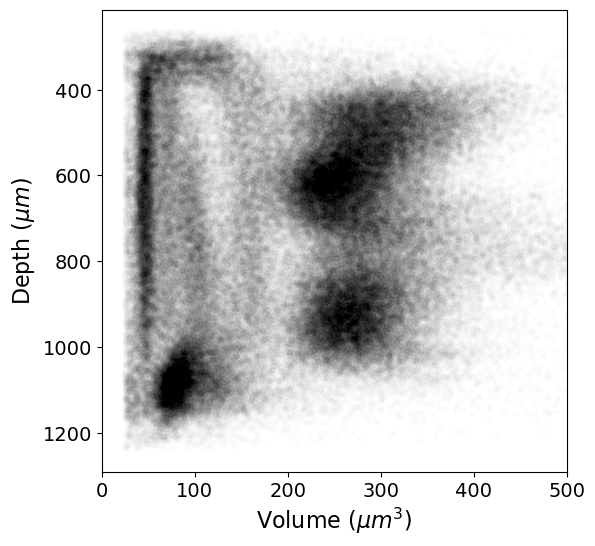

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.tick_params(labelsize=14)
sns.scatterplot(data=nucleus_df, x="volume", y="pt_position_y", size=1, edgecolor=None, alpha=.01, color="k", ax=ax, legend=False)
ax.invert_yaxis()
ax.set_xlabel("Volume ($\mu m^3$)", fontsize=16)
ax.set_ylabel("Depth ($\mu m$)", fontsize=16)
ax.set_xlim(0, 500)
plt.show()

### Querying cell type information 

There are two distinct ways cell types were classified in the MICrONS dataset: manual and automated. Manual annotations are available for ~1,300 neurons (`allen_v1_column_types_slanted_ref`), automated classifications are available for all cell bodies based on these manual annotations (`aibs_metamodel_celltypes_v661`). Because they are annotating an existing annotations, these annotations are introduced as a "reference" table:

In [12]:
ct_df = client.materialize.query_table("aibs_metamodel_celltypes_v661", desired_resolution=[1000, 1000, 1000], split_positions=True,
                                       merge_reference=False)

ct_df.head(5)

,id,created,superceded_id,valid,target_id,classification_system,cell_type
0,36916,2023-12-19 22:47:18.659864+00:00,NaN,t,336365,excitatory_neuron,5P-IT
1,1070,2023-12-19 22:38:00.472115+00:00,NaN,t,110648,excitatory_neuron,23P
2,1099,2023-12-19 22:38:00.898837+00:00,NaN,t,112071,excitatory_neuron,23P
3,13259,2023-12-19 22:41:14.417986+00:00,NaN,t,197927,nonneuron,oligo
4,13271,2023-12-19 22:41:14.685474+00:00,NaN,t,198087,nonneuron,astrocyte


Reference annotations contain `target_id` to merge them onto the table they target (here: the nucleus table). But do not worry, CAVE automatically merges them onto their target table by default (`merge_reference=True`):

In [13]:
ct_df = client.materialize.query_table("aibs_metamodel_celltypes_v661", desired_resolution=[1000, 1000, 1000], split_positions=True)
# remove segments with merged cell bodies — these are generally rare
ct_df = ct_df.drop_duplicates("pt_root_id", keep=False)
ct_df.head(5)

,id,created,valid,target_id,classification_system,cell_type,id_ref,created_ref,valid_ref,volume,...,pt_position_y,pt_position_z,bb_start_position_x,bb_start_position_y,bb_start_position_z,bb_end_position_x,bb_end_position_y,bb_end_position_z,pt_supervoxel_id,pt_root_id
0,36916,2023-12-19 22:47:18.659864+00:00,t,336365,excitatory_neuron,5P-IT,336365,2020-09-28 22:42:48.966292+00:00,t,272.488202,...,723.328,1083.04,NaN,NaN,NaN,NaN,NaN,NaN,93606511657924288,864691136274724621
1,1070,2023-12-19 22:38:00.472115+00:00,t,110648,excitatory_neuron,23P,110648,2020-09-28 22:45:09.650639+00:00,t,328.533443,...,518.528,1016.40,NaN,NaN,NaN,NaN,NaN,NaN,79385153184885329,864691135489403194
2,1099,2023-12-19 22:38:00.898837+00:00,t,112071,excitatory_neuron,23P,112071,2020-09-28 22:43:34.088785+00:00,t,272.929423,...,597.888,623.32,NaN,NaN,NaN,NaN,NaN,NaN,79035988248401958,864691136147292311
3,13259,2023-12-19 22:41:14.417986+00:00,t,197927,nonneuron,oligo,197927,2020-09-28 22:43:10.652649+00:00,t,91.308851,...,744.768,1058.84,NaN,NaN,NaN,NaN,NaN,NaN,84529699506051734,864691136050858227
4,13271,2023-12-19 22:41:14.685474+00:00,t,198087,nonneuron,astrocyte,198087,2020-09-28 22:41:36.677186+00:00,t,161.744978,...,763.776,1094.44,NaN,NaN,NaN,NaN,NaN,NaN,83756261929388963,864691135809440972


The reference table added two additional data columns: `classification_system` and `cell_type`. The `classification_system` divides the cells into excitatitory and inhibitory neurons as well as non-neuronal cells. `cell_type` provides lower level cell annotations.

In [14]:
ct_df["classification_system"].value_counts()

classification_system
excitatory_neuron    63761
nonneuron            18697
inhibitory_neuron     7849
Name: count, dtype: int64

In [15]:
ct_df["cell_type"].value_counts()

cell_type
23P          19643
4P           14722
6P-IT        11637
5P-IT         7889
astrocyte     7108
oligo         6900
6P-CT         6755
BC            3310
MC            2434
microglia     2394
5P-ET         2158
BPC           1484
OPC           1449
5P-NP          957
pericyte       846
NGC            621
Name: count, dtype: int64

### Location vs depth + Cell type


Because the cell type table contains the information about the nuclei, we can use it to plot the locations of all cell bodies as well and label them by type.

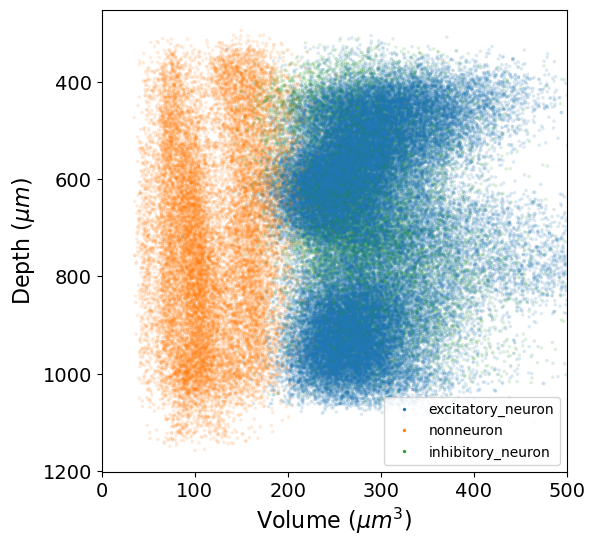

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.tick_params(labelsize=14)
sns.scatterplot(
    data=ct_df,
    x="volume",
    y="pt_position_y",
    s=5,
    edgecolor=None,
    alpha=.15,
    color="k",
    ax=ax, 
    legend=True,
    hue="classification_system",
)

ax.invert_yaxis()
ax.set_xlabel("Volume ($\mu m^3$)", fontsize=16)
ax.set_ylabel("Depth ($\mu m$)", fontsize=16)
ax.set_xlim(0, 500)

leg = plt.legend()
for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.show()

## Query 2: Querying synapses and proofread neurons

### Proofread neurons

Proofreading is necessary to obtain accurate reconstructions of a cell. In the MICrONS dataset, the general rule is that dendrites onto cells with a cell body are sufficiently proofread to trust synaptic connections onto a cell. Axons on the other hand require so much proofread that only ~1,000 cells have proofread axons for which outputs can be used for analysis.

The table `proofreading_status_and_strategy` contains proofreading information about ~1,200 neurons. Axon annotations `status_axon = "t"` and `clean` can be used for analysis. We can obtain such cells by adding a filter to our query:

In [17]:
proof_all_df = client.materialize.query_table("proofreading_status_and_strategy")

In [18]:
proof_all_df["strategy_axon"].value_counts()

strategy_axon
axon_partially_extended    979
axon_column_truncated      233
none                       185
axon_interareal            144
axon_fully_extended         80
Name: count, dtype: int64

In [19]:
proof_df = client.materialize.query_table("proofreading_status_and_strategy", filter_in_dict={"strategy_axon": ["axon_partially_extended", "axon_fully_extended", "axon_interareal"]})
proof_df

,id,created,superceded_id,valid,valid_id,status_dendrite,status_axon,strategy_dendrite,strategy_axon,pt_supervoxel_id,pt_root_id,pt_position
0,256,2024-06-03 19:45:52.683330+00:00,NaN,t,864691135697339034,t,t,dendrite_extended,axon_fully_extended,107470459595428444,864691135464714565,"[310384, 190160, 24525]"
1,1521,2024-08-02 20:25:55.933259+00:00,NaN,t,864691135700812066,t,t,dendrite_clean,axon_partially_extended,91138588351794214,864691136228491601,"[191536, 143552, 21481]"
2,1522,2024-08-02 20:25:55.998953+00:00,NaN,t,864691136445280131,t,t,dendrite_clean,axon_partially_extended,90782415236377623,864691136445280131,"[189296, 110976, 20651]"
3,1524,2024-08-02 20:25:56.032522+00:00,NaN,t,864691135059817627,t,t,dendrite_extended,axon_fully_extended,90570209626369807,864691135059817627,"[187504, 102896, 21656]"
4,1525,2024-08-02 20:25:56.051442+00:00,NaN,t,864691136424171823,t,t,dendrite_extended,axon_partially_extended,88038309225634916,864691136424171823,"[169008, 113040, 21735]"
...,...,...,...,...,...,...,...,...,...,...,...,...
1198,1346,2024-06-03 19:45:53.419339+00:00,NaN,t,864691136137871741,t,t,dendrite_extended,axon_partially_extended,97967311876627972,864691135953632803,"[241232, 165328, 24119]"
1199,1285,2024-06-03 19:45:53.378942+00:00,NaN,t,864691135545774376,t,t,dendrite_extended,axon_partially_extended,104581424140815209,864691135741659499,"[289680, 161264, 24791]"
1200,1288,2024-06-03 19:45:53.381018+00:00,NaN,t,864691135694026943,t,t,dendrite_extended,axon_partially_extended,113586080573545633,864691135741684075,"[354992, 142528, 23231]"
1201,1292,2024-06-03 19:45:53.383594+00:00,NaN,t,864691135123617831,t,t,dendrite_extended,axon_partially_extended,95641569704922650,864691135741721707,"[224336, 138864, 22805]"


In [20]:
root_id = 864691135808684573
client.chunkedgraph.get_tabular_change_log(root_id)[root_id]

,operation_id,timestamp,user_id,before_root_ids,after_root_ids,is_merge,user_name,user_affiliation
13,78709,1596313834289,161,"[864691134968357184, 864691136809752942]",[864691135686934240],True,Forrest Collman,
70,459622,1671675696607,3445,[864691135686934240],[864691136134988427],False,brendan_edits,
71,459629,1671675710153,3445,[864691136134988427],[864691135385872981],False,brendan_edits,
72,459632,1671675721098,3445,[864691135385872981],[864691135383026650],False,brendan_edits,
73,459635,1671675733562,3445,[864691135383026650],[864691136134988683],False,brendan_edits,
...,...,...,...,...,...,...,...,...
795,996407,1716932193081,5212,"[864691133783304229, 864691136618441179]",[864691135778652605],True,Erika Neace,Vortex
796,996408,1716932265654,5212,[864691135778652605],[864691135738172036],False,Erika Neace,Vortex
797,996409,1716932378857,5212,"[864691134299197358, 864691136120190357]",[864691135947189284],True,Erika Neace,Vortex
798,996411,1716932383573,5212,"[864691135738172036, 864691135947189284]",[864691134918745610],True,Erika Neace,Vortex


### Synapse query

The MICrONS dataset relies on automatically detected synapses for connectivity information. The consortium automatically detected and associated a total of 337 million synaptic clefts. The detections were evaluated by manually identifying synapses in 70 small subvolumes (n=8,611 synapses) distributed across the dataset, giving the automated detection an estimated precision of 96% and recall of 89% with a partner assignment accuracy of 98%.

We can query the synapse table directly. However, it is too large to query all at once. CAVE limits to queries to 500,000 rows at once and will display a warning when that happens. Here, we demonstrate this with the limit set to 10:

In [21]:
synapse_table_name = client.info.get_datastack_info()["synapse_table"]
syn_df = client.materialize.query_table(synapse_table_name, limit=10)
syn_df

201 - "Limited query to 10 rows


,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,4456,2020-11-04 13:02:08.388988+00:00,NaN,t,2956,72063160986635724,864691135533713769,72063160986635724,864691135533713769,"[52862, 102436, 20036]","[52862, 102436, 20036]","[52903, 102543, 20035]"
1,4503,2020-11-04 12:09:33.286834+00:00,NaN,t,344,72063092267156962,864691135087527094,72063092267156962,864691135087527094,"[53114, 102008, 20009]","[53114, 102008, 20009]","[53042, 102022, 20010]"
2,4508,2020-11-04 13:02:13.024144+00:00,NaN,t,344,72063229706111827,864691135533713769,72063229706111827,864691135533713769,"[53112, 102924, 20036]","[53112, 102924, 20036]","[53056, 102950, 20039]"
3,4568,2020-11-04 13:44:08.085705+00:00,NaN,t,13816,72133735889250131,864691134530418554,72133735889250131,864691134530418554,"[53348, 103862, 20073]","[53348, 103862, 20073]","[53274, 103794, 20072]"
4,4581,2020-11-04 07:29:12.917622+00:00,NaN,t,10436,72133804608718799,864691134745062676,72133804608718799,864691134745062676,"[53388, 104296, 20020]","[53388, 104296, 20020]","[53310, 104270, 20027]"
5,4582,2020-11-04 13:02:17.694701+00:00,NaN,t,1344,72063160986636743,864691135533713769,72063160986636743,864691135533713769,"[53220, 102280, 20036]","[53220, 102280, 20036]","[53254, 102208, 20038]"
6,4588,2020-11-04 12:20:12.290593+00:00,NaN,t,7128,72133942047682150,864691134609767690,72133942047682150,864691134609767690,"[53300, 105280, 20138]","[53300, 105280, 20138]","[53266, 105250, 20140]"
7,4590,2020-11-04 13:20:01.875310+00:00,NaN,t,6572,72133461011344162,864691135091400630,72133461011344162,864691135091400630,"[53376, 101610, 20129]","[53376, 101610, 20129]","[53334, 101649, 20130]"
8,4606,2020-11-04 07:24:39.038223+00:00,NaN,t,2100,72133667169766499,864691134609872906,72133667169766499,864691134609872906,"[53346, 103448, 20020]","[53346, 103448, 20020]","[53314, 103494, 20026]"
9,4611,2020-11-04 07:24:37.800341+00:00,NaN,t,492,72133735889243887,864691134609872906,72133735889243887,864691134609872906,"[53334, 103826, 20024]","[53334, 103826, 20024]","[53298, 103901, 20024]"


Instead we need to limit our query to a few neurons. We can query the graph spanned by the neurons with "clean" axons using the `filter_in_dict` parameter:

In [22]:
%%time 

synapse_table_name = client.info.get_datastack_info()["synapse_table"]
syn_df = client.materialize.query_table(synapse_table_name, 
                                        filter_in_dict={"pre_pt_root_id": proof_df["pt_root_id"], 
                                                        "post_pt_root_id": proof_df["pt_root_id"]})

# remove internal synapses — almost entirely false detections
syn_df = syn_df[syn_df["pre_pt_root_id"] != syn_df["post_pt_root_id"]]
syn_df

CPU times: total: 609 ms
Wall time: 2min 54s


,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,137764071,2020-11-04 09:39:48.804128+00:00,NaN,t,21584,87478245288662989,864691136389688695,87548614032842358,864691136239118908,"[165404, 134804, 20002]","[165552, 134850, 20005]","[165480, 134802, 19999]"
1,152094175,2020-11-04 07:20:36.943498+00:00,NaN,t,14020,88401010355440214,864691135778700477,88401010355435596,864691135561699041,"[171952, 194076, 19787]","[171996, 194038, 19786]","[172002, 194074, 19793]"
2,169627147,2020-11-04 06:48:58.480065+00:00,NaN,t,1932,89951734335675875,864691135463863102,89951734335679095,864691137197468481,"[182892, 213374, 21604]","[182934, 213366, 21611]","[182868, 213324, 21608]"
3,144648847,2020-11-04 10:25:21.607615+00:00,NaN,t,5720,87827409285525264,864691136389688695,87827409285520659,864691136143786292,"[167926, 114800, 22586]","[167920, 114768, 22583]","[167926, 114776, 22585]"
4,158842100,2020-11-04 10:11:44.081977+00:00,NaN,t,4388,89443553671426299,864691135988854016,89443553671436885,864691135954940424,"[179326, 97414, 20932]","[179398, 97350, 20942]","[179384, 97362, 20935]"
...,...,...,...,...,...,...,...,...,...,...,...,...
117001,173100472,2020-11-04 08:28:28.208230+00:00,NaN,t,6964,90293751104382021,864691135359413848,90293751104388154,864691136311213914,"[185624, 140482, 21162]","[185756, 140444, 21161]","[185678, 140456, 21163]"
117002,368508637,2020-11-04 10:36:39.850466+00:00,NaN,t,11364,105925439666802964,864691136445249923,105925439666815556,864691136137140093,"[299402, 213330, 24792]","[299440, 213472, 24795]","[299422, 213400, 24798]"
117003,161970989,2020-11-04 09:39:51.371123+00:00,NaN,t,2592,89384523841861858,864691136117421732,89314155097665442,864691135586346876,"[178802, 181790, 22157]","[178710, 181796, 22147]","[178769, 181687, 22151]"
117004,207210877,2020-11-04 08:37:58.524220+00:00,NaN,t,6172,92977865683131822,864691135566122071,92977865683131830,864691135701557115,"[205238, 215402, 25321]","[205334, 215396, 25320]","[205308, 215400, 25321]"


In [23]:
syn_df = client.materialize.synapse_query(pre_ids= proof_df["pt_root_id"], post_ids=proof_df["pt_root_id"])
syn_df

,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,152094175,2020-11-04 07:20:36.943498+00:00,NaN,t,14020,88401010355440214,864691135778700477,88401010355435596,864691135561699041,"[171952, 194076, 19787]","[171996, 194038, 19786]","[172002, 194074, 19793]"
1,137764071,2020-11-04 09:39:48.804128+00:00,NaN,t,21584,87478245288662989,864691136389688695,87548614032842358,864691136239118908,"[165404, 134804, 20002]","[165552, 134850, 20005]","[165480, 134802, 19999]"
2,144648847,2020-11-04 10:25:21.607615+00:00,NaN,t,5720,87827409285525264,864691136389688695,87827409285520659,864691136143786292,"[167926, 114800, 22586]","[167920, 114768, 22583]","[167926, 114776, 22585]"
3,190566409,2020-11-04 09:36:44.611944+00:00,NaN,t,4800,91429477896378071,864691136925825354,91429409176924802,864691135954940424,"[193774, 213248, 21169]","[193866, 213094, 21169]","[193832, 213172, 21166]"
4,158842100,2020-11-04 10:11:44.081977+00:00,NaN,t,4388,89443553671426299,864691135988854016,89443553671436885,864691135954940424,"[179326, 97414, 20932]","[179398, 97350, 20942]","[179384, 97362, 20935]"
...,...,...,...,...,...,...,...,...,...,...,...,...
117001,173100472,2020-11-04 08:28:28.208230+00:00,NaN,t,6964,90293751104382021,864691135359413848,90293751104388154,864691136311213914,"[185624, 140482, 21162]","[185756, 140444, 21161]","[185678, 140456, 21163]"
117002,368508637,2020-11-04 10:36:39.850466+00:00,NaN,t,11364,105925439666802964,864691136445249923,105925439666815556,864691136137140093,"[299402, 213330, 24792]","[299440, 213472, 24795]","[299422, 213400, 24798]"
117003,161970989,2020-11-04 09:39:51.371123+00:00,NaN,t,2592,89384523841861858,864691136117421732,89314155097665442,864691135586346876,"[178802, 181790, 22157]","[178710, 181796, 22147]","[178769, 181687, 22151]"
117004,207210877,2020-11-04 08:37:58.524220+00:00,NaN,t,6172,92977865683131822,864691135566122071,92977865683131830,864691135701557115,"[205238, 215402, 25321]","[205334, 215396, 25320]","[205308, 215400, 25321]"


Compared to the nucleus table, the synapse table has two points which were associated with segments (`pre_pt_position` and `post_pt_position`). The associated root ID columns are `pre_pt_root_id` and `post_pt_root_id`. 

Using pandas pivot function, we can transform this table into a matrix and plot it:

In [24]:
syn_mat = syn_df.pivot_table(index="pre_pt_root_id", columns="post_pt_root_id", values="size", aggfunc="sum")

# Squaring the matrix
syn_mat = syn_mat.reindex(columns=syn_mat.index)

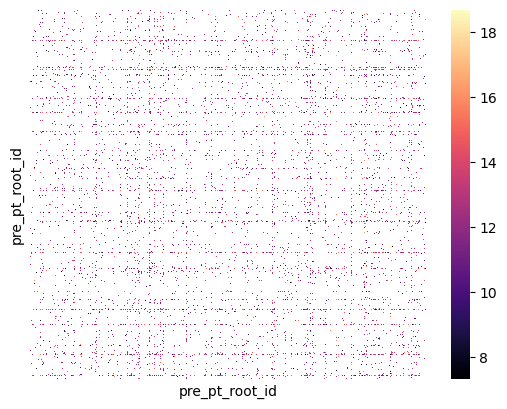

In [25]:
sns.heatmap(np.log2(syn_mat), cmap="magma", xticklabels=[], yticklabels=[])
plt.show()